Make sure you run the trials in *qme.ipynb* for $2 \leq nc \leq 5 $.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
import os

import sys
sys.path.append("../")
from common import qme_norm
from trials import NUM_TRIALS, load_qme_trial_summary, load_a_B

In [2]:
os.makedirs('plots', exist_ok=True)
os.makedirs('plots/qme', exist_ok=True)

In [3]:
mpl.rcParams['axes.linewidth'] = 2.0 # set the value globally
plt.rc('font', size=15)

In [4]:
data_dict = {
    # whether inputs to QME are well-formed
    True: {},
    False: {}
}

for wf in [True, False]:
    for c in range(2, 6): # classes        
        y1 = np.zeros(4) # a errors
        y2 = np.zeros(4) # B errors
        data_dict[wf][c] = [y1, y2]

In [5]:
for wf in [True, False]:
    for c in range(2, 6):
        a_err = None
        B_err = None
        try:
            a_err, B_err = load_qme_trial_summary(c, wf)
        except:
            print(f"missing class {c}")
            continue

        assert len(a_err) == NUM_TRIALS
        assert a_err.shape == B_err.shape
        data_dict[wf][c][0] = a_err
        data_dict[wf][c][1] = B_err

In [6]:
def analyze_data():
    '''
    Analyzes saved data for:
    sigma_maxes: max || B ||_F for any class
    baselines: errors on the following baselines:
        - ones: predict ones everywhere in (a, B) and normalize
    '''
    sigma_maxes = dict()
    
    # maps a baseline to [a_err, B_err]
    baselines = {
        "ones": dict() # baseline: ones everywhere in a, B; normalized
    }
    
    for nc in range(2, 6):
        for bl in baselines:
            baselines[bl][nc] = [ [], [] ] # a_err, B_err
    
    for nc in range(2, 6):
        q = nc ** 2 - nc
        max_F = 0
        # baseline_ones predicts 1's everywhere on a, B (and normalized so || a ||_2^2 + || B ||_F^2 = 1)
        baseline_a = np.ones(q)
        baseline_B = np.matrix(np.ones((q, q)))
        baseline_a, baseline_B = qme_norm(baseline_a, baseline_B)
        
        a_err_list = []
        B_err_list = []
        for i in range(NUM_TRIALS):
            # use well-formed for baselines
            a, B = load_a_B(nc, i, well_formed=True)
            # for sigma max
            fro_norm = np.linalg.norm(B, ord='fro')
            if fro_norm > max_F:
                max_F = fro_norm   
            
            # for baselines
            a_err = np.linalg.norm(baseline_a - a)
            B_err = np.linalg.norm(baseline_B - B, ord='fro')
            
            a_err_list.append(a_err)
            B_err_list.append(B_err)
                
        sigma_maxes[nc] = max_F
        baselines["ones"][nc][0] = a_err_list
        baselines["ones"][nc][1] = B_err_list
    
    return sigma_maxes, baselines

In [18]:
sigma_maxes, baselines = analyze_data()

# computes big-O theoretical bound of error
# returns [theor_a_err, theor_B_err]
def compute_theoretical_err(q, sigma_max):
    # these are in big-O, so they describe not the absolute error but the shape of the curve
    theor_a_err = q * (1e-2 + np.sqrt(sigma_max + 1e-2/1.0))
    theor_B_err = q * np.sqrt(q) * (1e-2 + np.sqrt(sigma_max + 1e-2/1.0))
    return [theor_a_err, theor_B_err]

def scale_theor_err(theor_err):
    # theoretical a error on class 5
    theor_5_a_err = theor_err[5][0]
    # average actual a error on class 5
    actual_5_a_err = np.mean( data_dict[True][5][0] )
    # scaler sc
    sc = actual_5_a_err / theor_5_a_err
    # scale values
    for c in theor_err:
        theor_err[c][0] *= sc
    
    # theoretical B error on class 5
    theor_5_B_err = theor_err[5][1]
    # average actual B error on class 5
    actual_5_B_err = np.mean( data_dict[True][5][1] )
    # scaler sc
    sc = actual_5_B_err / theor_5_B_err
    # scale values
    for c in theor_err:
        theor_err[c][1] *= sc

# this is not absolute, but rather shows the shape of error as the number of classes grows
theor_err = {i: compute_theoretical_err(i**2 - i, sigma_maxes[i]) for i in range(2, 6)}
# now theor_err is scaled so it can be graphed against the true error
scale_theor_err(theor_err)

# Plots

## Box and Whisker

In [8]:
def plot_general_bw(idx, ylabel, title, savepath):
    plt.figure(figsize=(8,5))
    wf = True # plot box-and-whisker for well-formed
    colors = {
        2: 'r',
        3: 'g',
        4: 'b',
        5: 'm',
    }
    x = [2, 3, 4, 5] # classes
    xticks = [xi**2 - xi for xi in x]
    
    errs = []
    for c in x:
        err = data_dict[wf][c][idx]
        errs.append(err)
    
    bp = plt.boxplot(errs, showfliers=False, positions=xticks, widths=2.5)
    
    # changing color and linewidth of 
    # whiskers 
    for whisker in bp['whiskers']: 
        whisker.set(color="#000000",
                    linewidth = 3.0, 
                    linestyle =":") 

    # changing color and linewidth of 
    # caps 
    for i, cap in enumerate(bp['caps']):
        cap.set(color = colors[i // 2 + 2], 
                linewidth = 2) 

    # changing color and linewidth of 
    # medians 
    for i, median in enumerate(bp['medians']): 
        median.set(color = colors[i + 2], 
                   linewidth = 3)
        
    plt.xlabel('$\mathbf{q = (k^2 - k)}$, k = # classes', fontsize = 24, weight = 'bold')
    plt.xticks(xticks, fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.ylabel(ylabel,  fontsize = 24, weight = 'bold')
    plt.title(title, fontsize = 24, weight = 'bold')
    
    if idx == 0:
        # a error is lower so we use scientific units
        plt.ticklabel_format(style='sci', axis='y', scilimits=(-3,-3))
    
    plt.tight_layout()
    print(f'saving to {savepath}')
    plt.savefig(savepath, format = "png", bbox_inches = "tight")
    plt.show()


def plot_a_bw():
    ylabel = r'$\mathbf{\Vert a - \hat a \Vert_2}$'
    title = 'Elicitation Error in a'
    savepath = "./plots/qme/qme_a_bw.png"
    plot_general_bw(0, ylabel, title, savepath)

#     plt.ylabel(r'$\mathbf{\Vert a - \hat a \Vert_2}$',  fontsize = '15', weight = 'bold')
#     plt.title('Elicitation Error in a', fontsize = '18', weight = 'bold')
#     plt.tight_layout()
    
def plot_b_bw():
    ylabel = r'$\mathbf{\Vert B - \hat B \Vert_F}$'
    title = 'Elicitation Error in B'
    savepath = "./plots/qme/qme_B_bw.png"
    plot_general_bw(1, ylabel, title, savepath)
    

saving to ./plots/qme/qme_a_bw.png


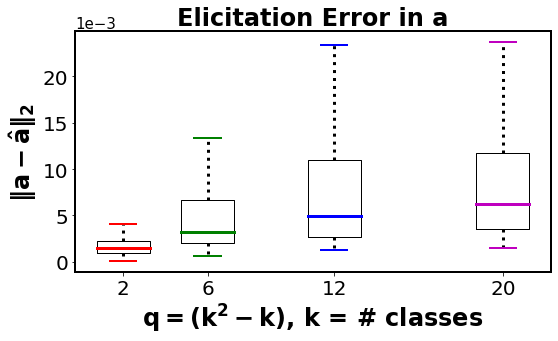

In [9]:
plot_a_bw()

saving to ./plots/qme/qme_B_bw.png


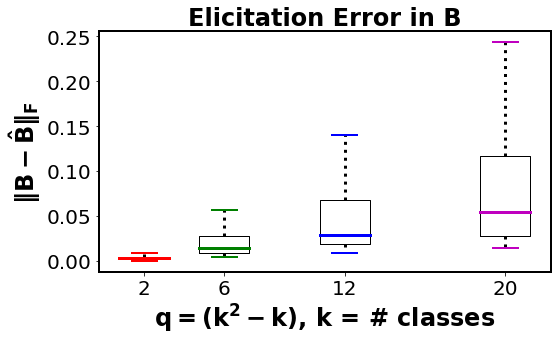

In [10]:
plot_b_bw()

## Well-Formed vs Ill-Formed

In [19]:
def plot_general_wf_if(idx, ylabel, title, savepath):
    colors = {
        # for well_formed vs ill_formed
        True: 'g',
        False: 'b',
        "theor": 'r',
    }

    linestyles = {
         # for well_formed vs ill_formed
        True: 'solid', # well_formed
        False: 'dashed', # ill_formed
        "theor": 'dashdot',

        # for baselines
        "qpme": 'solid',
        "ones": "dashed",
    }
    
    plt.figure(figsize=(8,5))
    
    # lines for wf and if
    wf_line = None
    if_line = None
    
    x = [2, 3, 4, 5] # classes
    xticks = [xi**2 - xi for xi in x]
    
    for c in x:
        for wf in [True, False]:
            err = data_dict[wf][c][idx]
            x_val = c ** 2 - c
            if wf:
                x_val -= 0.1
            else:
                x_val += 0.1
            
            ret = plt.errorbar([x_val], [np.mean(err)], yerr=[np.std(err)],
                                 elinewidth=1,
                                 capsize=2,
                                 linewidth=3,
                                 fmt='-.o',
                                 ecolor=colors[wf],
                                 color=colors[wf],
                                )
            
            # set linestyle of errorbars
            ret.lines[-1][0].set_linestyle(linestyles[wf])
            
            # set wf_line, if_line
            if wf_line is None:
                wf_line = ret.lines[-1][0]
                wf_line.set_label("w Assumption 4")
            elif if_line is None:
                if_line = ret.lines[-1][0]
                if_line.set_label("w/o Assumption 4")
    
    # plot theoretical
    y = [theor_err[c][idx] for c in x]
    theor_lines = plt.plot(xticks, y, color=colors["theor"], linestyle=linestyles["theor"])
    theor_line = theor_lines[0]
    theor_line.set_label("theoretical")
            
    plt.legend( handles = [wf_line, if_line, theor_line], loc = 'upper left', prop={'size': 18})
    
    plt.xlabel('$\mathbf{q = (k^2 - k)}$, k = # classes', fontsize = 24, weight = 'bold')
    plt.xticks(xticks, fontsize=20)
    plt.yticks(fontsize=20)

    plt.ylabel(ylabel,  fontsize = 24, weight = 'bold')
    plt.title(title, fontsize = 24, weight = 'bold')
    
    if idx == 0:
        # a error is lower so we use scientific units
        plt.ticklabel_format(style='sci', axis='y', scilimits=(-3,-3))
    
    plt.tight_layout()
    print(f'saving to {savepath}')
    plt.savefig(savepath, format = "png", bbox_inches = "tight")
    plt.show()


def plot_a_wf_if():
    ylabel = r'$\mathbf{\Vert a - \hat a \Vert_2}$'
    title = 'a Elicitation Error - QPME'
    savepath = "./plots/qme/qme_a.png"
    plot_general_wf_if(0, ylabel, title, savepath)

    
def plot_b_wf_if():
    ylabel = r'$\mathbf{\Vert B - \hat B \Vert_F}$'
    title = 'B Elicitation Error - QPME'
    savepath = "./plots/qme/qme_B.png"
    plot_general_wf_if(1, ylabel, title, savepath)

saving to ./plots/qme/qme_a.png


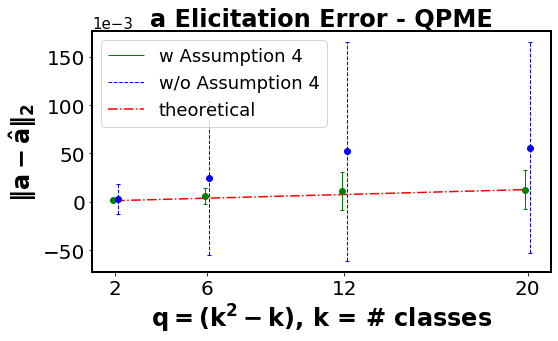

In [20]:
plot_a_wf_if()

saving to ./plots/qme/qme_B.png


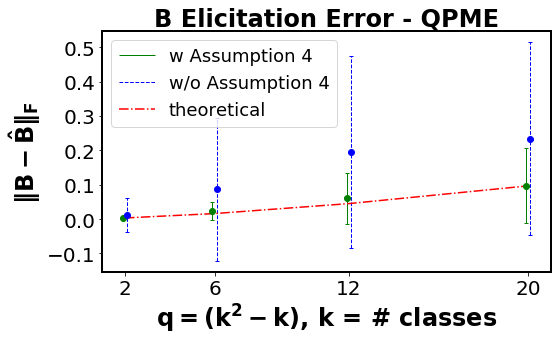

In [21]:
plot_b_wf_if()

## Baselines

In [22]:
def plot_baseline_ones(idx, ylabel, title, savepath):
    colors = {
        # for baselines
        "qpme": 'g',
        "ones": "b",
    }
    
    linestyles = {
        # for baselines
        "qpme": 'solid',
        "ones": "dashed",
    }
    
    plt.figure(figsize=(8,5))
    
    qpme_line = None
    ones_line = None
    
    x = [2, 3, 4, 5] # classes
    xticks = [xi**2 - xi for xi in x]
    for c in x:
        err = data_dict[True][c][idx]
        q = c**2 - c

        # qpme
        ret = plt.errorbar([q], [np.mean(err)], yerr=[np.std(err)],
                             elinewidth=1,
                             capsize=2,
                             linewidth=3,
                             fmt='-.o',
                             ecolor=colors["qpme"],
                             color=colors["qpme"],
                            )
        
        # set linestyle of errorbars
        ret.lines[-1][0].set_linestyle(linestyles["qpme"])
        if qpme_line is None:
            qpme_line = ret.lines[-1][0]
            qpme_line.set_label("qpme")

        # baseline ones
        err = baselines["ones"][c][idx]
        ret = plt.errorbar([q], [np.mean(err)], yerr=[np.std(err)],
                             elinewidth=1,
                             capsize=2,
                             linewidth=3,
                             fmt='-.o',
                             ecolor=colors["ones"],
                             color=colors["ones"],
                            )
        
        # set linestyle of errorbars
        ret.lines[-1][0].set_linestyle(linestyles["ones"])
        if ones_line is None:
            ones_line = ret.lines[-1][0]
            ones_line.set_label("eq. coeff")
    
    plt.legend( handles = [qpme_line, ones_line], loc = 'best', prop={'size': 18})

    plt.xlabel('$\mathbf{q = (k^2 - k)}$, k = # classes', fontsize = 24, weight = 'bold')
    plt.xticks(xticks, fontsize=20)
    plt.yticks(fontsize=20)

    plt.ylabel(ylabel,  fontsize = 24, weight = 'bold')
    plt.title(title, fontsize = 24, weight = 'bold')
    
    if idx == 0:
        # a error is lower so we use scientific units
        plt.ticklabel_format(style='sci', axis='y', scilimits=(-3,-3))
    
    plt.tight_layout()
    print(f'saving to {savepath}')
    plt.savefig(savepath, format = "png", bbox_inches = "tight")
    plt.show()
    
    
def plot_a_baseline():
    ylabel = r'$\mathbf{\Vert a - \hat a \Vert_2}$'
    title = 'a Baseline Error'
    savepath = "./plots/qme/qme_a_baseline.png"
    plot_baseline_ones(0, ylabel, title, savepath)

    
def plot_b_baseline():
    ylabel = r'$\mathbf{\Vert B - \hat B \Vert_F}$'
    title = 'B Baseline Error'
    savepath = "./plots/qme/qme_B_baseline.png"
    plot_baseline_ones(1, ylabel, title, savepath)

saving to ./plots/qme/qme_a_baseline.png


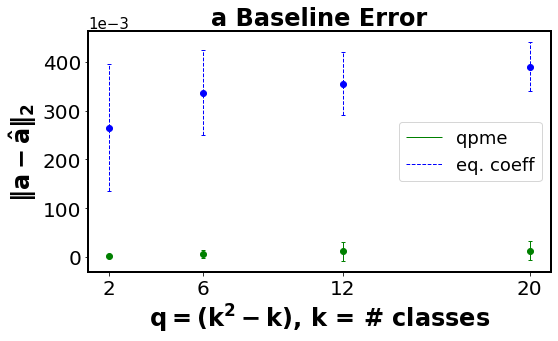

In [23]:
plot_a_baseline()

saving to ./plots/qme/qme_B_baseline.png


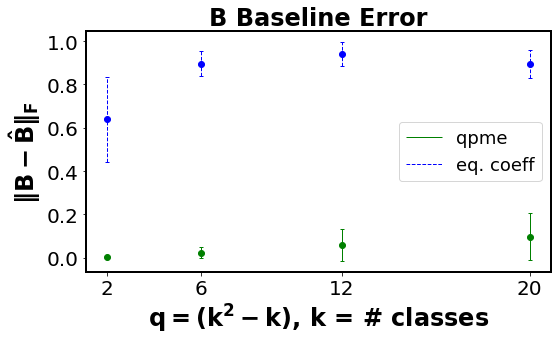

In [24]:
plot_b_baseline()